In [1]:
import os
import urllib

import pandas as pd

from cell_type_naming import nice_to_weirds, weird_to_nice

In [2]:
experiment_name = "with_bmode"
experiment_uri = os.path.join("gs://liulab/csx_experiments/varying_simple_parameters", experiment_name)

experiment_uri

'gs://liulab/csx_experiments/varying_simple_parameters/with_bmode'

In [3]:
!gsutil --quiet rm -r $experiment_uri

In [4]:
mixture_source = "gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/mixture_melanoma_Tirosh_SuppFig_3b-d.txt"
# mixture_filename = os.path.basename(mixture_source)
mixture_filename = "mymixture.txt"
mixture_target = os.path.join(experiment_uri, "in", mixture_filename)

!gsutil cp $mixture_source $mixture_target

sc_refsample_source = "gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/scRNA-Seq_reference_melanoma_Tirosh_SuppFig_3b-d.txt"
# sc_refsample_filename = os.path.basename(sc_refsample_source)
sc_refsample_filename = "myscrefsample.txt"
sc_refsample_target = os.path.join(experiment_uri, "in", sc_refsample_filename)

!gsutil cp $sc_refsample_source $sc_refsample_target

Copying gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/mixture_melanoma_Tirosh_SuppFig_3b-d.txt [Content-Type=text/plain]...
/ [1 files][  6.0 MiB/  6.0 MiB]                                                
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/scRNA-Seq_reference_melanoma_Tirosh_SuppFig_3b-d.txt [Content-Type=text/plain]...
/ [1 files][ 87.8 MiB/ 87.8 MiB]                                                
Operation completed over 1 objects/87.8 MiB.                                     


In [5]:
experiment_path = "/mnt/buckets/liulab" + urllib.parse.urlparse(experiment_uri).path

In [6]:
!tree -h $experiment_path

/mnt/buckets/liulab/csx_experiments/varying_simple_parameters/with_bmode
└── [   0]  in
    ├── [6.0M]  mymixture.txt
    └── [ 88M]  myscrefsample.txt

1 directory, 2 files


In [7]:
command = f'''docker run \
    --rm \
    -v {experiment_path}/in:/src/data \
    -v {experiment_path}:/src/outdir \
    --user "$(id -u):$(id -g)" \
    cibersortx/fractions:latest \
    --username lyronctk@stanford.edu \
    --token dfeba2c8b9d61daebee5fa87026b8e56 \
    --single_cell TRUE \
    --refsample {sc_refsample_filename} \
    --mixture {mixture_filename} \
    --rmbatchBmode TRUE \
    --verbose TRUE
'''.replace("    ", " \\\n    ")
print(command)

docker run \
     --rm \
     -v /mnt/buckets/liulab/csx_experiments/varying_simple_parameters/with_bmode/in:/src/data \
     -v /mnt/buckets/liulab/csx_experiments/varying_simple_parameters/with_bmode:/src/outdir \
     --user "$(id -u):$(id -g)" \
     cibersortx/fractions:latest \
     --username lyronctk@stanford.edu \
     --token dfeba2c8b9d61daebee5fa87026b8e56 \
     --single_cell TRUE \
     --refsample myscrefsample.txt \
     --mixture mymixture.txt \
     --rmbatchBmode TRUE \
     --verbose TRUE



In [8]:
!{command}

>Running CIBERSORTxFractions...
>[Options] username: lyronctk@stanford.edu
>[Options] token: dfeba2c8b9d61daebee5fa87026b8e56
>[Options] single_cell: TRUE
>[Options] refsample: myscrefsample.txt
>[Options] mixture: mymixture.txt
>[Options] rmbatchBmode: TRUE
>[Options] verbose: TRUE
>Making reference sample file.
>Making phenotype class file.
>single_cell is set to TRUE, so quantile normalization is set to FALSE, and the default parameters for building the signature matrix have been set to the following values:
	- G.min <- 300
	- G.max <- 500
	- q.value <- 0.01
>==========Signature Matrix Settings============
>Pure samples file: /src/outdir//CIBERSORTx_myscrefsample_inferred_refsample.txt
>Phenotype classes file: /src/outdir//CIBERSORTx_myscrefsample_inferred_phenoclasses.txt
>Minimum number of DEGs to consider from each phenotype for signature matrix set to: 300
>Maximum number of DEGs to consider from each phenotype for signature matrix set to: 500
>Q-value for signature matrix const

In [9]:
!tree -h $experiment_path

/mnt/buckets/liulab/csx_experiments/varying_simple_parameters/with_bmode
├── [4.3K]  CIBERSORTx_Adjusted.txt
├── [988K]  CIBERSORTx_Mixtures_Adjusted.txt
├── [3.8M]  CIBERSORTx_cell_type_sourceGEP.txt
├── [172K]  CIBERSORTx_myscrefsample_inferred_phenoclasses.CIBERSORTx_myscrefsample_inferred_refsample.bm.K999.pdf
├── [510K]  CIBERSORTx_myscrefsample_inferred_phenoclasses.CIBERSORTx_myscrefsample_inferred_refsample.bm.K999.txt
├── [ 725]  CIBERSORTx_myscrefsample_inferred_phenoclasses.txt
├── [ 18M]  CIBERSORTx_myscrefsample_inferred_refsample.txt
└── [   0]  in
    ├── [6.0M]  mymixture.txt
    └── [ 88M]  myscrefsample.txt

1 directory, 9 files


In [10]:
fractions_csx = pd.read_csv(
    os.path.join(experiment_uri, "CIBERSORTx_Adjusted.txt"),
    sep="\t",
    index_col=0
).rename_axis(index="mixture_id").rename(columns=weird_to_nice).iloc[:, :-3]

fractions_csx.sample(5)

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
mixture_id,,,,,,,,
65,0.085071,0.000728,0.000000,0.317211,0.021196,0.033165,0.459450,0.083178
75,0.012174,0.000052,0.000000,0.685369,0.069268,0.021474,0.208972,0.002692
71,0.443202,0.000643,0.002281,0.312400,0.033853,0.039054,0.166721,0.001847
67,0.000000,0.000000,0.000000,0.273097,0.038581,0.005893,0.497270,0.185159
58,0.000000,0.000000,0.003011,0.640688,0.070722,0.021656,0.247513,0.016409


In [11]:
signature_matrix = pd.read_csv(
    os.path.join(experiment_uri, "CIBERSORTx_myscrefsample_inferred_phenoclasses.CIBERSORTx_myscrefsample_inferred_refsample.bm.K999.txt"),
    sep="\t",
    index_col=0
).rename_axis(index="gene").rename(columns=weird_to_nice)

signature_matrix.sample(5)

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
gene,,,,,,,,
LOX,1.00000,53.011314,524.750014,1.000000,1.000000,1.000000,1.000000,1.000000
LOC100130476,1.00000,1.000000,1.000000,85.932509,1.000000,1.000000,56.335926,1.000000
PTPN7,1.00000,1.000000,1.000000,156.983553,67.672359,1.000000,181.110947,28.379187
SDS,1.00000,1.000000,1.000000,1.000000,1.000000,29.030163,1.000000,1.000000
ALDH3B2,36.48977,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
fractions_truth = pd.read_csv(
    "gs://liulab/csx_example_files/groundtruth_Melanoma_Tirosh_et_al_SuppFig3b-d.txt",
    sep="\t",
    index_col=0,
).rename_axis(index="mixture_id").rename(columns=weird_to_nice)

fractions_truth.sample(5)

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
mixture_id,,,,,,,,
67,0.0000,0.0000,0.0000,0.3059,0.0118,0.0000,0.4588,0.2235
82,0.4638,0.0000,0.0870,0.1304,0.0290,0.0580,0.2174,0.0145
84,0.1045,0.0075,0.0075,0.1716,0.0522,0.1866,0.2836,0.1866
71,0.6835,0.0000,0.0000,0.1899,0.0000,0.0253,0.1013,0.0000
88,0.3966,0.0000,0.0068,0.1559,0.0305,0.1356,0.2203,0.0542


In [18]:
import plotly.io
plotly.io.renderers.default = "jupyterlab+png"

import plotly.express as px
import plotly.graph_objects as go

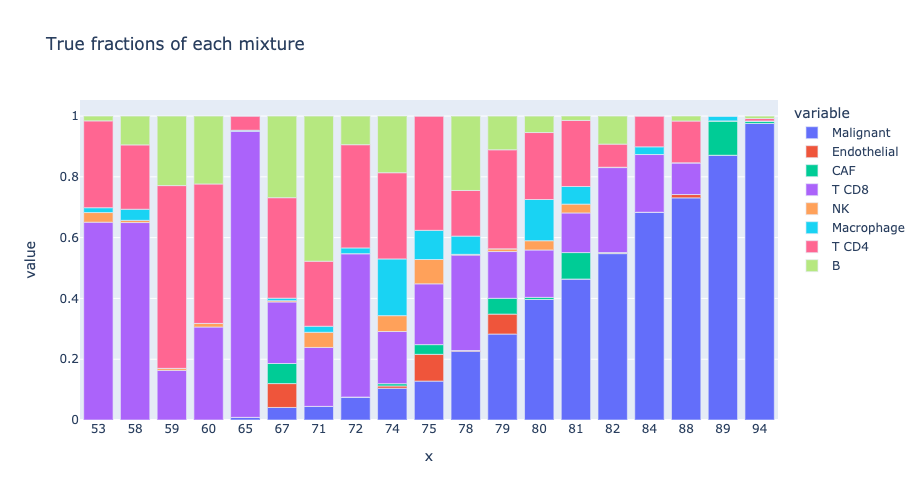

In [25]:
fig = px.bar(
    fractions_truth.sort_values(by="Malignant"),  #.astype(index={"mixture_id": str}),
    x=fractions_truth.index.astype(str),
    y=fractions_truth.columns,
    title="True fractions of each mixture"
)

fig.show()

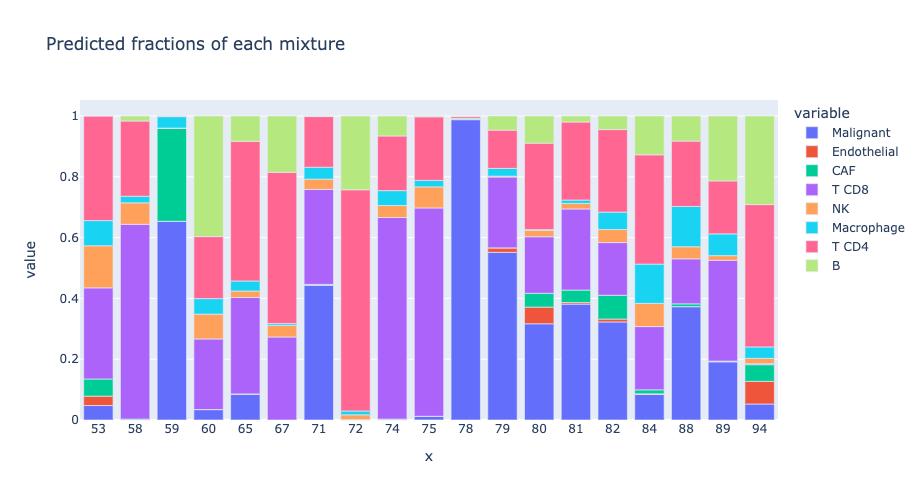

In [20]:
fig = px.bar(
    fractions_csx,  #.astype(index={"mixture_id": str}),
    x=fractions_csx.index.astype(str),
    y=fractions_csx.columns,
    title="Predicted fractions of each mixture"
)

fig.show()